# ADC data analytics

Anarysing ADC data recorded by Intel MAX10 FPGA. I compare ADC raw data and processed data by FIR filter in FPGA. The ADC sampling rate is 1Mps. The cutoff ratio of FIR filter is 0.1.

## Common parameters and functions

In [1]:
import pandas as pd
import numpy as np
import math
import statistics

# Parameters
#@title Parameters
FREQUENCY = 10**6 #@param [type:"integer"]
LEGEND_LABEL = ['Raw data', 'Processed data']

# Functions
def min_max(l):
    """
    Min-Max Normalization.
    
    Parameters
    ----------
    l : list
        Data list.
    
    Returns
    -------
    data_normalization : list
        Normalization data list
    """
    l_min = min(l)
    l_max = max(l)
    return [(i - l_min) / (l_max - l_min) for i in l]

def standardization(l):
    """
    Standardization.
    
    Parameters
    ----------
    l : list
        Data list.
    
    Returns
    -------
    data_standardization : list
        Standardization data list
    """
    l_mean = statistics.mean(l)
    l_stdev = statistics.stdev(l)
    return [(i - l_mean) / l_stdev for i in l]

def load_data(filename):
    """
    Load text data file that terminated with '\n'.
    
    Parameters
    ----------
    filename : string
        File name.

    Returns
    -------
    data : list
        Data list in loaded file.
    """
    try:
        with open(filename, "r") as file:
            data = np.loadtxt(filename)
            return data
    except IOError:
        raise Exception("Unable to open file")
        return None

def generate_window_data(data):
    """
    Generate product of data and window function.
    
    Parameters
    ----------
    data : list
        Orignal data.
    
    Returns
    -------
    fft_data : list
        product of window function.
    """
    window_data = []
    wf = np.hanning(len(data))
    for i in range(len(data)):
        window_data.append(data[i] * wf[i])
    return window_data

def generate_power_spectrum(data):
    """
    Genarate power spectrum by using FFT data
    
    Parameters
    ----------
    data : list
        FFT data.
    
    Returns
    -------
    power_spectrum : list
        Power spectrum data.
    """
    power_spectrum = []
    for i in data:
        power_spectrum.append(10*math.log10(2*abs(i)))
    return power_spectrum

## Noise data


Max amplitude of raw data is 0.7488853942821043
Max amplitude of processed data is 0.33761002042839916
Standard deviation of raw data is 199.38250464722083
Standard deviation of processed data is 52.924150729404204


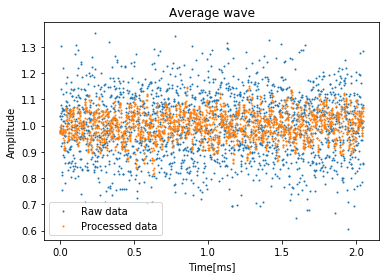

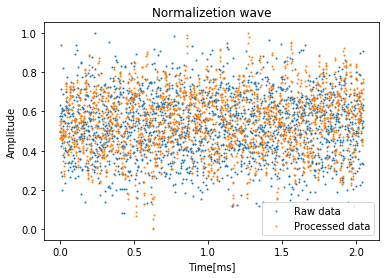

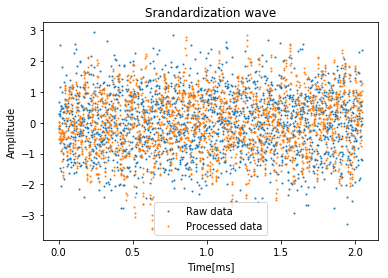

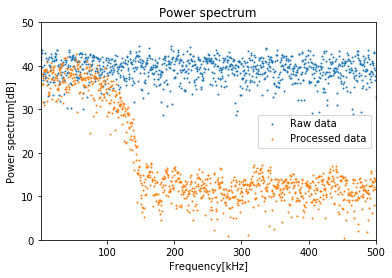

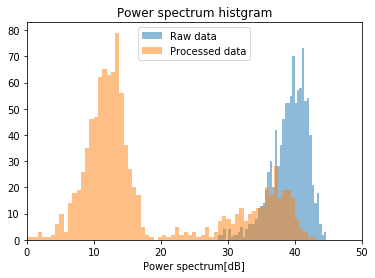

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

# Raw data file load
#@title Data file
noise_raw_file = "noise_raw.dat" #@param [type:"string"]
noise_raw_data = load_data(noise_raw_file)

# Processed data file load
#@title Data file
noise_processed_file = "noise_processed.dat" #@param [type:"string"]
noise_processed_data = load_data(noise_processed_file)

noise_raw_average       = statistics.mean(noise_raw_data)
noise_processed_average = statistics.mean(noise_processed_data)

print("Max amplitude of raw data is", (max(noise_raw_data) - min(noise_raw_data))/noise_raw_average)
print("Max amplitude of processed data is", (max(noise_processed_data) - min(noise_processed_data))/noise_processed_average)
print("Standard deviation of raw data is", np.std(noise_raw_data))
print("Standard deviation of processed data is", np.std(noise_processed_data))

# Wave data plot
t = np.linspace(0, len(noise_raw_data)/FREQUENCY*10**3,num=len(noise_raw_data))

# Average
plt.scatter(t, noise_raw_data/noise_raw_average,             s=1)
plt.scatter(t, noise_processed_data/noise_processed_average, s=1)
plt.title('Average wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Normalizetion
plt.scatter(t, min_max(noise_raw_data),       s=1)
plt.scatter(t, min_max(noise_processed_data), s=1)
plt.title('Normalizetion wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Srandardization
plt.scatter(t, standardization(noise_raw_data),       s=1)
plt.scatter(t, standardization(noise_processed_data), s=1)
plt.title('Srandardization wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Fourier Transform
k = np.linspace(0, FREQUENCY/2/10**3,num=len(noise_raw_data)/2)
noise_raw_fft       = np.fft.fft(generate_window_data(noise_raw_data))
noise_processed_fft = np.fft.fft(generate_window_data(noise_processed_data))
noise_raw_fft_half       = noise_raw_fft[0:len(k)]
noise_processed_fft_half = noise_processed_fft[0:len(k)]

# Power spectrum
noise_raw_ps       = generate_power_spectrum(noise_raw_fft_half)
noise_processed_ps = generate_power_spectrum(noise_processed_fft_half) 
plt.scatter(k, noise_raw_ps,        s=1)
plt.scatter(k, noise_processed_ps , s=1)
# plt.xscale('log')
plt.xlim([1,500])
plt.ylim([0,50])
plt.title('Power spectrum')
plt.xlabel('Frequency[kHz]')
plt.ylabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

# Histgram
BIN_SIZE = 100 #@param [type:"integer"]
plt.hist(noise_raw_ps,       bins=BIN_SIZE, alpha=0.5)
plt.hist(noise_processed_ps, bins=BIN_SIZE, alpha=0.5)
plt.xlim([0,50])
plt.title('Power spectrum histgram')
plt.xlabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

The processed data, comparing with the raw data, is clearly seen suppressed amplitude from the standard deviation and the average wave graph. but no difference in normalizetion and standardization. From the power spectrum graph, the processed data has the inflection point on frequency = 100kHz. It means the cutoff frequency of FIR filter is 100kHz. It is also find from cutoff ratio = 0.1 and sampling rate = 1Mps. From histgram, power spectrum of the pocessed data is suppressed by about 30dB.

## 100kHz sin signal

Max amplitude of raw data is 1.0035713642221435
Max amplitude of processed data is 0.4761272018109071
Standard deviation of raw data is 578.5203260065131
Standard deviation of processed data is 173.11447437390908


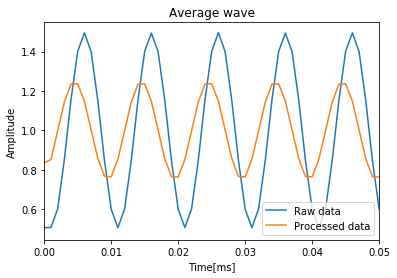

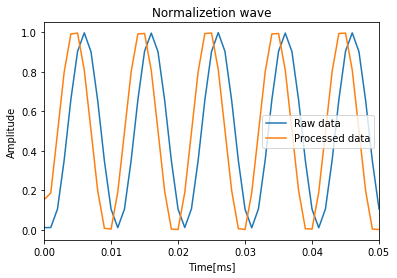

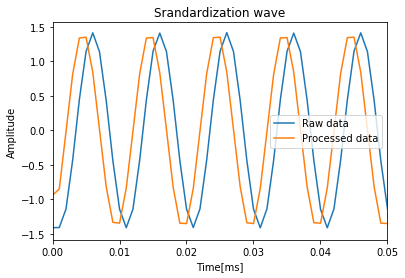

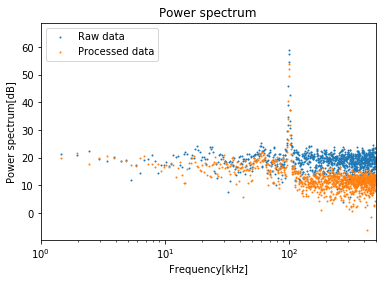

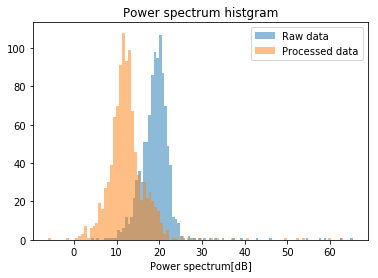

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

# Raw data file load
#@title Data file
s100k_raw_file = "sin_100k_raw.dat" #@param [type:"string"]
s100k_raw_data = load_data(s100k_raw_file)

# Processed data file load
#@title Data file
s100k_processed_file = "sin_100k_processed.dat" #@param [type:"string"]
s100k_processed_data = load_data(s100k_processed_file)

s100k_raw_average       = statistics.mean(s100k_raw_data)
s100k_processed_average = statistics.mean(s100k_processed_data)

print("Max amplitude of raw data is", (max(s100k_raw_data) - min(s100k_raw_data))/s100k_raw_average)
print("Max amplitude of processed data is", (max(s100k_processed_data) - min(s100k_processed_data))/s100k_processed_average)
print("Standard deviation of raw data is", np.std(s100k_raw_data))
print("Standard deviation of processed data is", np.std(s100k_processed_data))

# Wave data plot
t = np.linspace(0, len(s100k_raw_data)/FREQUENCY*10**3,num=len(s100k_raw_data))

# Average
plt.plot(t, s100k_raw_data/s100k_raw_average)
plt.plot(t, s100k_processed_data/s100k_processed_average)
plt.xlim([0,0.05])
plt.title('Average wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Normalizetion
plt.plot(t, min_max(s100k_raw_data))
plt.plot(t, min_max(s100k_processed_data))
plt.xlim([0,0.05])
plt.title('Normalizetion wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Srandardization
plt.plot(t, standardization(s100k_raw_data))
plt.plot(t, standardization(s100k_processed_data))
plt.xlim([0,0.05])
plt.title('Srandardization wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Fourier Transform
k = np.linspace(0, FREQUENCY/2/10**3,num=len(s100k_raw_data)/2)
s100k_raw_fft       = np.fft.fft(generate_window_data(s100k_raw_data))
s100k_processed_fft = np.fft.fft(generate_window_data(s100k_processed_data))
s100k_raw_fft_half       = s100k_raw_fft[0:len(k)]
s100k_processed_fft_half = s100k_processed_fft[0:len(k)]

# Power spectrum
s100k_raw_ps       = generate_power_spectrum(s100k_raw_fft_half)
s100k_processed_ps = generate_power_spectrum(s100k_processed_fft_half) 
plt.scatter(k, s100k_raw_ps,       s=1)
plt.scatter(k, s100k_processed_ps, s=1)
plt.xscale('log')
plt.xlim([1,500])
plt.title('Power spectrum')
plt.xlabel('Frequency[kHz]')
plt.ylabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

# Histgram
BIN_SIZE = 100 #@param [type:"integer"]
plt.hist(s100k_raw_ps,       bins=BIN_SIZE, alpha=0.5)
plt.hist(s100k_processed_ps, bins=BIN_SIZE, alpha=0.5)
# plt.xlim([0,50])
plt.title('Power spectrum histgram')
plt.xlabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

100kHz sin signal is also seen suppressed amplitude from the standard deviation and the average wave graph. Since the cutoff frequency is equal to the frequency of 100kHz sin signal, the amplitude of 100kHz sin signal is suppressed. The power spectrum graph stands sharp edge of 100kHz sin signal.

## 10kHz sin signal

Max amplitude of raw data is 0.9982410921564505
Max amplitude of processed data is 0.9871955195374094
Standard deviation of raw data is 578.4925205780422
Standard deviation of processed data is 346.25720119458936


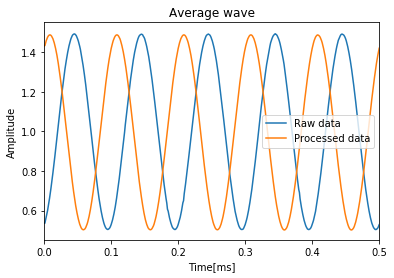

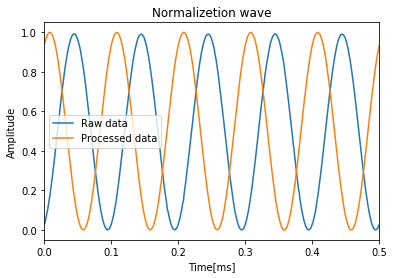

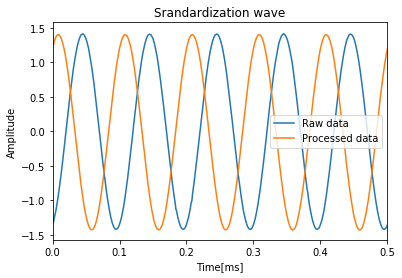

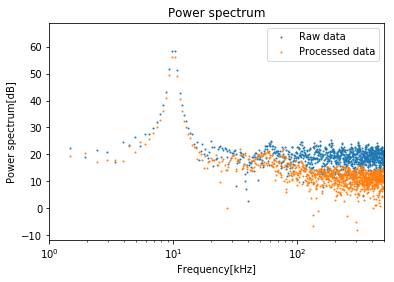

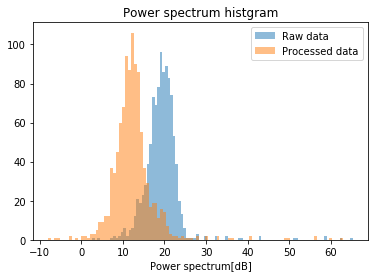

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

# Raw data file load
#@title Data file
s10k_raw_file = "sin_10k_raw.dat" #@param [type:"string"]
s10k_raw_data = load_data(s10k_raw_file)

# Processed data file load
#@title Data file
s10k_processed_file = "sin_10k_processed.dat" #@param [type:"string"]
s10k_processed_data = load_data(s10k_processed_file)

s10k_raw_average       = statistics.mean(s10k_raw_data)
s10k_processed_average = statistics.mean(s10k_processed_data)

print("Max amplitude of raw data is", (max(s10k_raw_data) - min(s10k_raw_data))/s10k_raw_average)
print("Max amplitude of processed data is", (max(s10k_processed_data) - min(s10k_processed_data))/s10k_processed_average)
print("Standard deviation of raw data is", np.std(s10k_raw_data))
print("Standard deviation of processed data is", np.std(s10k_processed_data))

# Wave data plot
t = np.linspace(0, len(s10k_raw_data)/FREQUENCY*10**3,num=len(s10k_raw_data))

# Average
plt.plot(t, s10k_raw_data/s10k_raw_average)
plt.plot(t, s10k_processed_data/s10k_processed_average)
plt.xlim([0,0.5])
plt.title('Average wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Normalizetion
plt.plot(t, min_max(s10k_raw_data))
plt.plot(t, min_max(s10k_processed_data))
plt.xlim([0,0.5])
plt.title('Normalizetion wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Srandardization
plt.plot(t, standardization(s10k_raw_data))
plt.plot(t, standardization(s10k_processed_data))
plt.xlim([0,0.5])
plt.title('Srandardization wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Fourier Transform
k = np.linspace(0, FREQUENCY/2/10**3,num=len(s10k_raw_data)/2)
s10k_raw_fft       = np.fft.fft(generate_window_data(s10k_raw_data))
s10k_processed_fft = np.fft.fft(generate_window_data(s10k_processed_data))
s10k_raw_fft_half       = s10k_raw_fft[0:len(k)]
s10k_processed_fft_half = s10k_processed_fft[0:len(k)]

# Power spectrum
s10k_raw_ps       = generate_power_spectrum(s10k_raw_fft_half)
s10k_processed_ps = generate_power_spectrum(s10k_processed_fft_half) 
plt.scatter(k, s10k_raw_ps,       s=1)
plt.scatter(k, s10k_processed_ps, s=1)
plt.xscale('log')
plt.xlim([1,500])
plt.title('Power spectrum')
plt.xlabel('Frequency[kHz]')
plt.ylabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

# Histgram
BIN_SIZE = 100 #@param [type:"integer"]
plt.hist(s10k_raw_ps,       bins=BIN_SIZE, alpha=0.5)
plt.hist(s10k_processed_ps, bins=BIN_SIZE, alpha=0.5)
# plt.xlim([0,50])
plt.title('Power spectrum histgram')
plt.xlabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

## 1kHz sin signal

Max amplitude of raw data is 0.988291880260743
Max amplitude of processed data is 1.0056024871526419
Standard deviation of raw data is 579.1161789233624
Standard deviation of processed data is 350.09782455104045


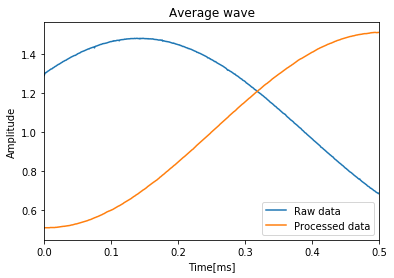

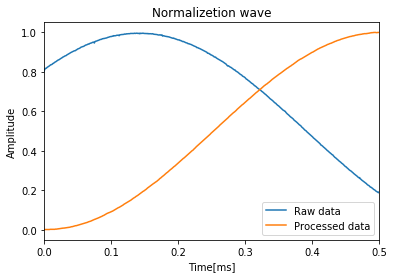

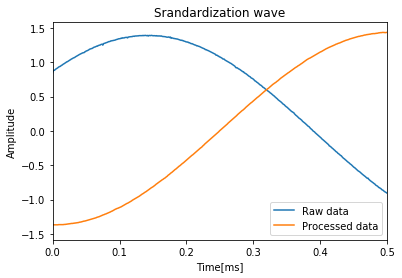

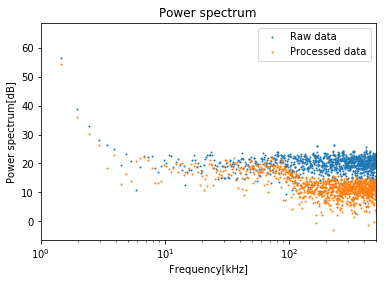

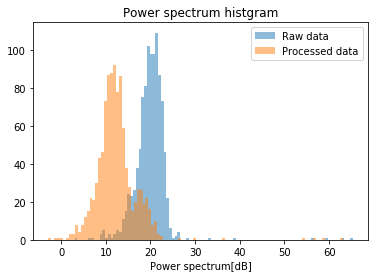

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

# Raw data file load
#@title Data file
s1k_raw_file = "sin_1k_raw.dat" #@param [type:"string"]
s1k_raw_data = load_data(s1k_raw_file)

# Processed data file load
#@title Data file
s1k_processed_file = "sin_1k_processed.dat" #@param [type:"string"]
s1k_processed_data = load_data(s1k_processed_file)

s1k_raw_average       = statistics.mean(s1k_raw_data)
s1k_processed_average = statistics.mean(s1k_processed_data)

print("Max amplitude of raw data is", (max(s1k_raw_data) - min(s1k_raw_data))/s1k_raw_average)
print("Max amplitude of processed data is", (max(s1k_processed_data) - min(s1k_processed_data))/s1k_processed_average)
print("Standard deviation of raw data is", np.std(s1k_raw_data))
print("Standard deviation of processed data is", np.std(s1k_processed_data))

# Wave data plot
t = np.linspace(0, len(s1k_raw_data)/FREQUENCY*10**3,num=len(s1k_raw_data))

# Average
plt.plot(t, s1k_raw_data/s1k_raw_average)
plt.plot(t, s1k_processed_data/s1k_processed_average)
plt.xlim([0,0.5])
plt.title('Average wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Normalizetion
plt.plot(t, min_max(s1k_raw_data))
plt.plot(t, min_max(s1k_processed_data))
plt.xlim([0,0.5])
plt.title('Normalizetion wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Srandardization
plt.plot(t, standardization(s1k_raw_data))
plt.plot(t, standardization(s1k_processed_data))
plt.xlim([0,0.5])
plt.title('Srandardization wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Fourier Transform
k = np.linspace(0, FREQUENCY/2/10**3,num=len(s1k_raw_data)/2)
s1k_raw_fft       = np.fft.fft(generate_window_data(s1k_raw_data))
s1k_processed_fft = np.fft.fft(generate_window_data(s1k_processed_data))
s1k_raw_fft_half       = s1k_raw_fft[0:len(k)]
s1k_processed_fft_half = s1k_processed_fft[0:len(k)]

# Power spectrum
s1k_raw_ps       = generate_power_spectrum(s1k_raw_fft_half)
s1k_processed_ps = generate_power_spectrum(s1k_processed_fft_half) 
plt.scatter(k, s1k_raw_ps,       s=1)
plt.scatter(k, s1k_processed_ps, s=1)
plt.xscale('log')
plt.xlim([1,500])
plt.title('Power spectrum')
plt.xlabel('Frequency[kHz]')
plt.ylabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

# Histgram
BIN_SIZE = 100 #@param [type:"integer"]
plt.hist(s1k_raw_ps,       bins=BIN_SIZE, alpha=0.5)
plt.hist(s1k_processed_ps, bins=BIN_SIZE, alpha=0.5)
# plt.xlim([0,50])
plt.title('Power spectrum histgram')
plt.xlabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

## 10kHz square wave

Max amplitude of raw data is 1.0042009810218422
Max amplitude of processed data is 1.1215766595754957
Standard deviation of raw data is 807.2056161085886
Standard deviation of processed data is 471.95106754167085


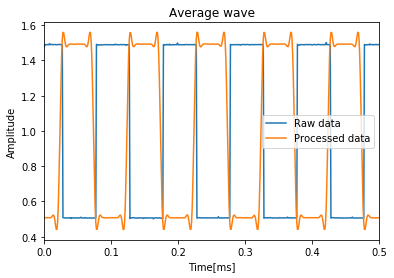

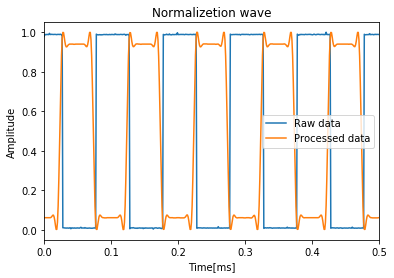

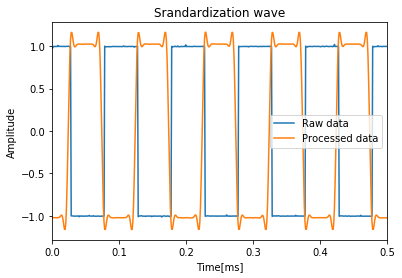

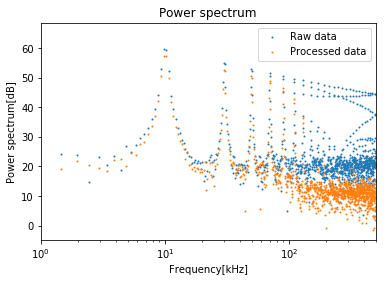

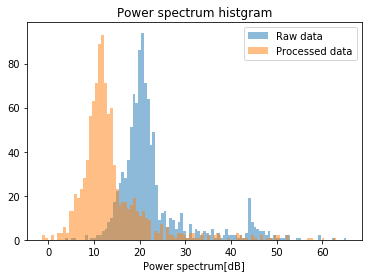

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

# Raw data file load
#@title Data file
sq10k_raw_file = "sq_10k_raw.dat" #@param [type:"string"]
sq10k_raw_data = load_data(sq10k_raw_file)

# Processed data file load
#@title Data file
sq10k_processed_file = "sq_10k_processed.dat" #@param [type:"string"]
sq10k_processed_data = load_data(sq10k_processed_file)

sq10k_raw_average       = statistics.mean(sq10k_raw_data)
sq10k_processed_average = statistics.mean(sq10k_processed_data)

print("Max amplitude of raw data is", (max(sq10k_raw_data) - min(sq10k_raw_data))/sq10k_raw_average)
print("Max amplitude of processed data is", (max(sq10k_processed_data) - min(sq10k_processed_data))/sq10k_processed_average)
print("Standard deviation of raw data is", np.std(sq10k_raw_data))
print("Standard deviation of processed data is", np.std(sq10k_processed_data))

# Wave data plot
t = np.linspace(0, len(sq10k_raw_data)/FREQUENCY*10**3,num=len(sq10k_raw_data))

# Average
plt.plot(t, sq10k_raw_data/sq10k_raw_average)
plt.plot(t, sq10k_processed_data/sq10k_processed_average)
plt.xlim([0,0.5])
plt.title('Average wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Normalizetion
plt.plot(t, min_max(sq10k_raw_data))
plt.plot(t, min_max(sq10k_processed_data))
plt.xlim([0,0.5])
plt.title('Normalizetion wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Srandardization
plt.plot(t, standardization(sq10k_raw_data))
plt.plot(t, standardization(sq10k_processed_data))
plt.xlim([0,0.5])
plt.title('Srandardization wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Fourier Transform
k = np.linspace(0, FREQUENCY/2/10**3,num=len(sq10k_raw_data)/2)
sq10k_raw_fft       = np.fft.fft(generate_window_data(sq10k_raw_data))
sq10k_processed_fft = np.fft.fft(generate_window_data(sq10k_processed_data))
sq10k_raw_fft_half       = sq10k_raw_fft[0:len(k)]
sq10k_processed_fft_half = sq10k_processed_fft[0:len(k)]

# Power spectrum
sq10k_raw_ps       = generate_power_spectrum(sq10k_raw_fft_half)
sq10k_processed_ps = generate_power_spectrum(sq10k_processed_fft_half) 
plt.scatter(k, sq10k_raw_ps,       s=1)
plt.scatter(k, sq10k_processed_ps, s=1)
plt.xscale('log')
plt.xlim([1,500])
plt.title('Power spectrum')
plt.xlabel('Frequency[kHz]')
plt.ylabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

# Histgram
BIN_SIZE = 100 #@param [type:"integer"]
plt.hist(sq10k_raw_ps,       bins=BIN_SIZE, alpha=0.5)
plt.hist(sq10k_processed_ps, bins=BIN_SIZE, alpha=0.5)
# plt.xlim([0,50])
plt.title('Power spectrum histgram')
plt.xlabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

## 1kHz square wave

Max amplitude of raw data is 1.0241899999116444
Max amplitude of processed data is 1.1066006249532072
Standard deviation of raw data is 807.4436015880275
Standard deviation of processed data is 482.300737432066


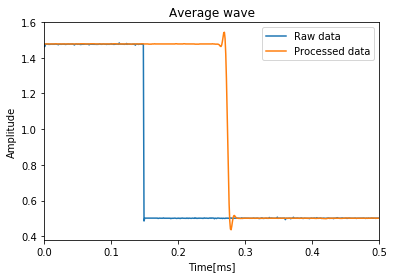

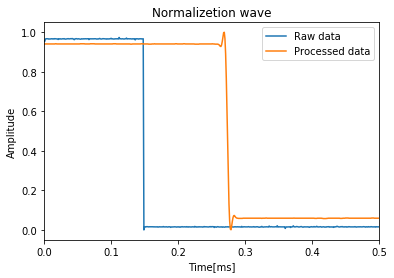

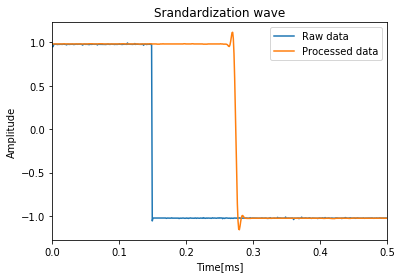

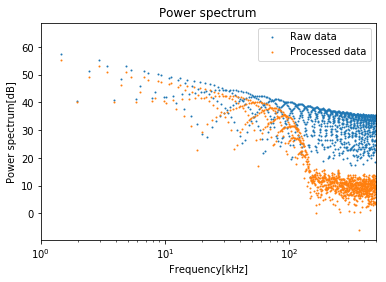

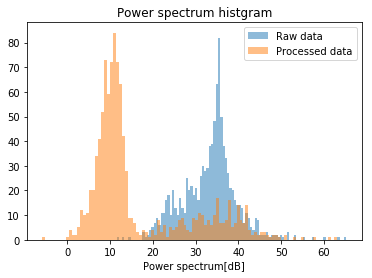

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

# Raw data file load
#@title Data file
sq1k_raw_file = "sq_1k_raw.dat" #@param [type:"string"]
sq1k_raw_data = load_data(sq1k_raw_file)

# Processed data file load
#@title Data file
sq1k_processed_file = "sq_1k_processed.dat" #@param [type:"string"]
sq1k_processed_data = load_data(sq1k_processed_file)

sq1k_raw_average       = statistics.mean(sq1k_raw_data)
sq1k_processed_average = statistics.mean(sq1k_processed_data)

print("Max amplitude of raw data is", (max(sq1k_raw_data) - min(sq1k_raw_data))/sq1k_raw_average)
print("Max amplitude of processed data is", (max(sq1k_processed_data) - min(sq1k_processed_data))/sq1k_processed_average)
print("Standard deviation of raw data is", np.std(sq1k_raw_data))
print("Standard deviation of processed data is", np.std(sq1k_processed_data))

# Wave data plot
t = np.linspace(0, len(sq1k_raw_data)/FREQUENCY*10**3,num=len(sq1k_raw_data))

# Average
plt.plot(t, sq1k_raw_data/sq1k_raw_average)
plt.plot(t, sq1k_processed_data/sq1k_processed_average)
plt.xlim([0,0.5])
plt.title('Average wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Normalizetion
plt.plot(t, min_max(sq1k_raw_data))
plt.plot(t, min_max(sq1k_processed_data))
plt.xlim([0,0.5])
plt.title('Normalizetion wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Srandardization
plt.plot(t, standardization(sq1k_raw_data))
plt.plot(t, standardization(sq1k_processed_data))
plt.xlim([0,0.5])
plt.title('Srandardization wave')
plt.xlabel('Time[ms]')
plt.ylabel('Amplitude')
plt.legend(LEGEND_LABEL)
plt.show()

# Fourier Transform
k = np.linspace(0, FREQUENCY/2/10**3,num=len(sq1k_raw_data)/2)
sq1k_raw_fft       = np.fft.fft(generate_window_data(sq1k_raw_data))
sq1k_processed_fft = np.fft.fft(generate_window_data(sq1k_processed_data))
sq1k_raw_fft_half       = sq1k_raw_fft[0:len(k)]
sq1k_processed_fft_half = sq1k_processed_fft[0:len(k)]

# Power spectrum
sq1k_raw_ps       = generate_power_spectrum(sq1k_raw_fft_half)
sq1k_processed_ps = generate_power_spectrum(sq1k_processed_fft_half) 
plt.scatter(k, sq1k_raw_ps,       s=1)
plt.scatter(k, sq1k_processed_ps, s=1)
plt.xscale('log')
plt.xlim([1,500])
plt.title('Power spectrum')
plt.xlabel('Frequency[kHz]')
plt.ylabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()

# Histgram
BIN_SIZE = 100 #@param [type:"integer"]
plt.hist(sq1k_raw_ps,       bins=BIN_SIZE, alpha=0.5)
plt.hist(sq1k_processed_ps, bins=BIN_SIZE, alpha=0.5)
# plt.xlim([0,50])
plt.title('Power spectrum histgram')
plt.xlabel('Power spectrum[dB]')
plt.legend(LEGEND_LABEL)
plt.show()